# Итоговый проект Модуля 2: Исследовательский анализ данных пользователей Яндекс.Афиша

## Цели и задачи проекта

Цель: провести исследовательский анализ данных, чтобы понять, какие пользователи повторно возвращаются на платформу и делают заказы. Это позволит выявлять перспекивных клиентов, точнее настраивать таргетинг на рекламе, оптимизировать маркетинговые бюджеты

Задачи:

1. Загрузить и подготовить данные для исследования
2. Предобработка данных
3. Подготовка профиля пользователя
4. Исследовательский анализ
5. Корелляционный анализ
6. Подготовка выводов и рекомендаций


### 1. Загрузка и подготовка данных для исследования

#### 1.1 Настройка подключения и выгрузка данных из БД

In [1]:
# Проводим установку библитотек для работы с SQL
!pip install sqlalchemy

In [2]:
# Проводим установку адаптера для подключения к базе данных
!pip install psycopg2 

In [3]:
# Устанавливаем зависимости
!pip install -i https://test.pypi.org/simple/ psycopg2-binary==2.9.3

Looking in indexes: https://test.pypi.org/simple/


In [4]:
# Импортируем pandas - основную библиотеку для анализа и работы с данными
import pandas as pd
from sqlalchemy import create_engine 

In [5]:
# Готовим конфиг для подключения к нужной схеме данных
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             } 

In [6]:
# Указываем маппинг полей конфигурации
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [7]:
# Подключаемся к БД с настроенным конфигом
engine = create_engine(connection_string)

In [8]:
# Определяем запрос, который подготовит нужную выборку данных
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
  SELECT ap.user_id,
         ap.device_type_canonical,
         ap.order_id,
         ap.created_dt_msk AS order_dt,
         ap.created_ts_msk AS order_ts,
         ap.currency_code,
         ap.revenue,
         ap.tickets_count,
         (ap.created_dt_msk::date - LAG(ap.created_dt_msk::date) OVER (PARTITION BY ap.user_id ORDER BY ap.created_dt_msk ASC))
         AS days_since_prev,
         ap.event_id,
         ae.event_name_code AS event_name,
         ae.event_type_main,
         ap.service_name,
         ar.region_name,
         ac.city_name
  FROM afisha.purchases AS ap
  LEFT JOIN afisha.events AS ae USING (event_id)
  LEFT JOIN afisha.city AS ac USING (city_id)
  LEFT JOIN afisha.regions AS ar USING (region_id)
  WHERE device_type_canonical IN ('mobile', 'desktop') 
  AND event_type_main != 'фильм'
  ORDER BY ap.user_id ASC
'''

In [9]:
# Выгружаем результаты нашего запроса в датафрейм
df = pd.read_sql_query(query, con=engine)

In [10]:
# Запрашиваем информацию о получившемся датафрейме для подтверждения, что данные успешно выгружены
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

#### 1.2 Выводы

Данные успешно получены из БД, согласно нашему SQL запросу. Датафрейм состоит из 14 столбцов и 290611 строк. Пропуски данных есть только в столбце days_since_prev - это говорит о том, что не все пользователи делали более 1 заказа и предыдущих заказов у части строк - нет.
На этапе предобработки заполнять эти пропуски скорее всего не потребуется.
Можно предположить, что потребуется изменить тип данных у части полей с object на более удобный для работы, например, строки для полей Название города, Регион, Название события


### 2. Предобработка данных

#### 2.1 Приведение данных к одной валюте

In [11]:
# Загрузим данные по курсу казахстанского тенге
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [12]:
# Проверим загруженные данные

tenge_df.info()
tenge_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


В загруженном датафрейме содержатся данные о курсе тенге к рублю в формате: стоимость 100 тенге в рублях на определенную дату.
Это позволит нам перевести стоимость заказов в тенге в рубли по курсу на дату заказа

In [13]:
# Для начала необходимо привести столбец data к типу datetime. Напрямую это сделать не получится, потому сначала переведем object -> str,
# а после - str -> datetime

tenge_df['data'] = tenge_df['data'].astype('str')
tenge_df['data'] = pd.to_datetime(tenge_df['data'])
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [14]:
# Создадим новый объединенный датафрейм, добавив к заказам курсы тенге. Далее проведем перевод тенге в рубли и сохраним в исходный датафрейм

# Отфильтруем заказы в тенге в отдельный датафрейм
kzt_df = df.loc[df['currency_code'] == 'kzt']

# Объединим в один датафрейм с курсом тенге
kztrub_df = kzt_df.merge(tenge_df, left_on='order_dt', right_on='data', how='left')
kztrub_df.info()
kztrub_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5069 entries, 0 to 5068
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                5069 non-null   object        
 1   device_type_canonical  5069 non-null   object        
 2   order_id               5069 non-null   int64         
 3   order_dt               5069 non-null   datetime64[ns]
 4   order_ts               5069 non-null   datetime64[ns]
 5   currency_code          5069 non-null   object        
 6   revenue                5069 non-null   float64       
 7   tickets_count          5069 non-null   int64         
 8   days_since_prev        4201 non-null   float64       
 9   event_id               5069 non-null   int64         
 10  event_name             5069 non-null   object        
 11  event_type_main        5069 non-null   object        
 12  service_name           5069 non-null   object        
 13  reg

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx
0,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-17,100,19.0125,kzt
1,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-02,100,18.9330,kzt
2,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-09,100,18.5991,kzt
3,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,2024-06-11,100,19.8928,kzt
4,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,2024-06-04,100,19.9833,kzt


In [15]:
# Посчитаем стоимость заказов в рублях согласно курсу валют и сохраним в новый столбец
for i in kztrub_df:
    kztrub_df['revenue_rub'] = kztrub_df['revenue'] / 100 * kztrub_df['curs']

In [16]:
# Проверим полученные данные
kztrub_df.info()
kztrub_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5069 entries, 0 to 5068
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                5069 non-null   object        
 1   device_type_canonical  5069 non-null   object        
 2   order_id               5069 non-null   int64         
 3   order_dt               5069 non-null   datetime64[ns]
 4   order_ts               5069 non-null   datetime64[ns]
 5   currency_code          5069 non-null   object        
 6   revenue                5069 non-null   float64       
 7   tickets_count          5069 non-null   int64         
 8   days_since_prev        4201 non-null   float64       
 9   event_id               5069 non-null   int64         
 10  event_name             5069 non-null   object        
 11  event_type_main        5069 non-null   object        
 12  service_name           5069 non-null   object        
 13  reg

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx,revenue_rub
0,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-17,100,19.0125,kzt,98.503762
1,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-02,100,18.9330,kzt,65.731589
2,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-09,100,18.5991,kzt,61.148261
3,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,2024-06-11,100,19.8928,kzt,4380.702898
4,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,2024-06-04,100,19.9833,kzt,1478.296591


In [17]:
# Теперь нужно добавить полученное значение в исходный датафрейм. Для этого выделим столбцы order_id и revenue_rub и добавим их в 
# исходный датафрейм

transfer_df = kztrub_df[['order_id', 'revenue_rub']]
transfer_df.info()

df = df.merge(transfer_df, how='left', on='order_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5069 entries, 0 to 5068
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   order_id     5069 non-null   int64  
 1   revenue_rub  5069 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 79.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count      

In [18]:
# Пройдем в цикле все строки датафрейма и заполним пустые значения revenue_rub значениями revenue
for i in df:
    df['revenue_rub'] = df['revenue_rub'].fillna(df['revenue'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

#### 2.2 Проверка на пропуски, формат и тип данных. Фильтрация

Пропуски данных присутствуют только в days_since_prev. 

Можно преобразовать тип данных в поле days_since_prev в int. Также можно сократить размерность данных в столбцах: 
order_id до int32, 
days_since_prev до float32,
tickets_count до int8,
event_id до int32

In [19]:
# Проведем нужные преобразования и проверим датафрейм

df['days_since_prev'] = pd.to_numeric(df['days_since_prev'], downcast='float')
df['order_id'] = pd.to_numeric(df['order_id'], downcast='integer')
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')
df['event_id'] = pd.to_numeric(df['event_id'], downcast='integer')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [21]:
# Выведем количество уникальных значений по столбцам

df.nunique()

user_id                   21933
device_type_canonical         2
order_id                 290611
order_dt                    153
order_ts                 280753
currency_code                 2
revenue                   42522
tickets_count                22
days_since_prev             149
event_id                  22427
event_name                15248
event_type_main               7
service_name                 36
region_name                  81
city_name                   352
revenue_rub               43691
dtype: int64

In [22]:
# Выведем уникальные значения по номинальным данным

df['device_type_canonical'].unique()

array(['mobile', 'desktop'], dtype=object)

In [23]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

In [24]:
# Проведем исследование распределения численных данных и выбросов в них. Нас интересуют поля: revenue_rub и tickets_count

df['revenue_rub'].describe()

count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

In [25]:
df['tickets_count'].describe()

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

In [26]:
# Выведем визуализацию распределения, для этого подключим библиотеки seaborn и matplotlib

import seaborn as sns
import matplotlib.pyplot as plt

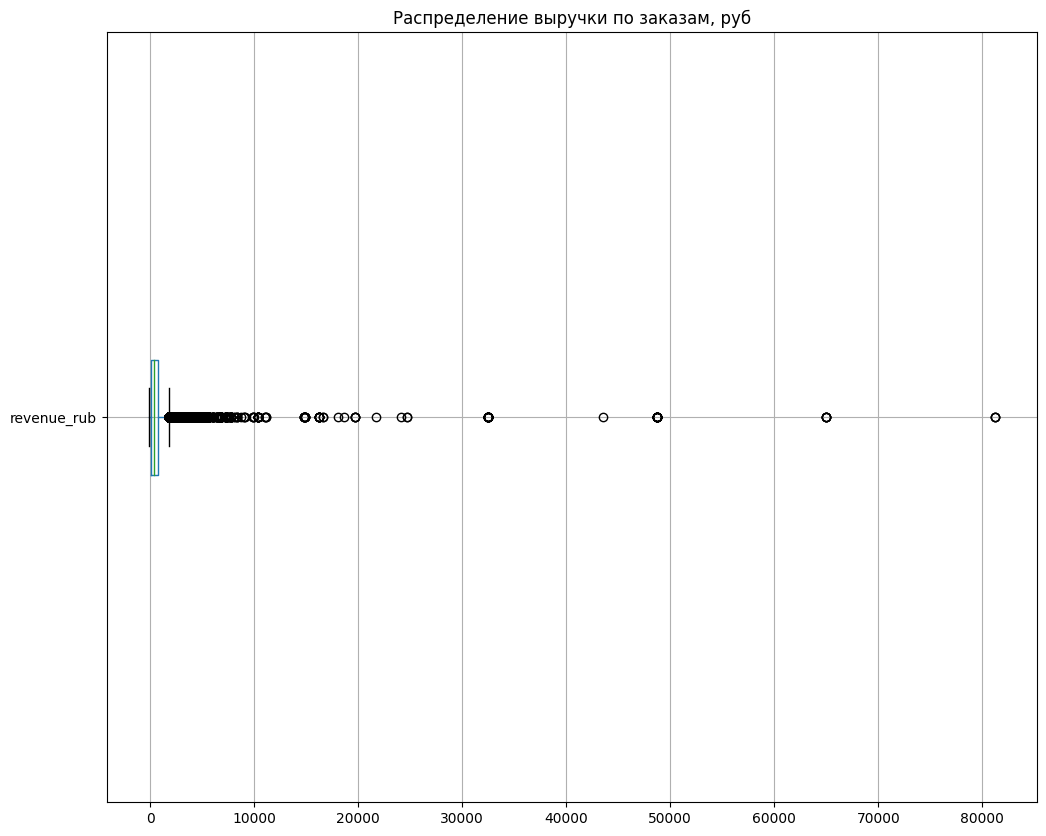

In [27]:
# Построим диаграммы размаха и гистограммы распределения по интересующим полям

plot1 = df.boxplot(column='revenue_rub',
           vert=False,
           grid=True,
           figsize=(12, 10))

plot1.set_title('Распределение выручки по заказам, руб')
plt.show()

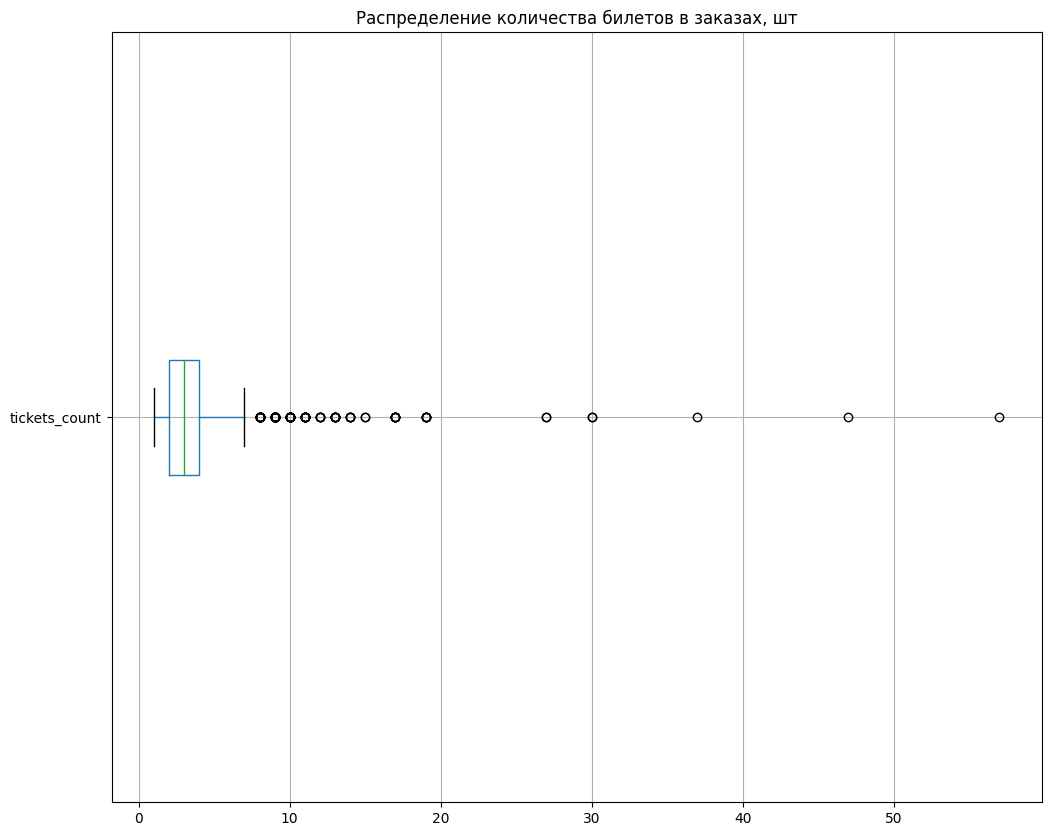

In [28]:
plot2 = df.boxplot(column='tickets_count',
           vert=False,
           grid=True,
           figsize=(12, 10))

plot2.set_title('Распределение количества билетов в заказах, шт')
plt.show()

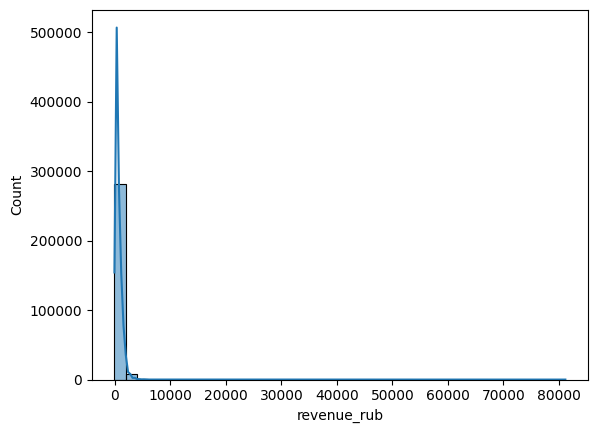

In [29]:
sns.histplot(data=df, x='revenue_rub', bins=40, kde=True)

plt.show()

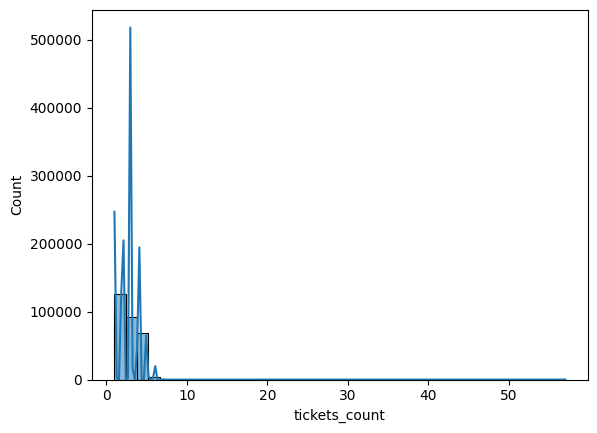

In [30]:
sns.histplot(data=df, x='tickets_count', bins=40, kde=True)
plt.show()

Оба поля содержат выбросы, в поле revenue_rub также присутствуют аномальные значения (отрицательные). Для получения более качественных данных
необходимо отфильтровать revenue_rub по значениям выше нуля, и также по 99% персентилю, чтобы исключить аномальные выбросы
По полю tickets_count аномально высоких или отрицательных значений нет, потому фильтровать данные не будем

In [31]:
# Находим 99 персентиль по полю revenue_rub

pers99 = df['revenue_rub'].quantile(0.99)

# Фильтруем данные по значению 99 персентиля  и выше 0

filtered_df = df.loc[(df['revenue_rub']<pers99) & (df['revenue_rub']>0)]

# Проверяем

filtered_df.info()

# Количество отфильтрованных строк
print(f'В результате фильтрации выборка уменьшена на: {df.shape[0] - filtered_df.shape[0]} строк, что составляет {round((df.shape[0] - filtered_df.shape[0]) / df.shape[0] * 100, 1)} %' )

<class 'pandas.core.frame.DataFrame'>
Index: 281697 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                281697 non-null  object        
 1   device_type_canonical  281697 non-null  object        
 2   order_id               281697 non-null  int32         
 3   order_dt               281697 non-null  datetime64[ns]
 4   order_ts               281697 non-null  datetime64[ns]
 5   currency_code          281697 non-null  object        
 6   revenue                281697 non-null  float64       
 7   tickets_count          281697 non-null  int8          
 8   days_since_prev        260323 non-null  float32       
 9   event_id               281697 non-null  int32         
 10  event_name             281697 non-null  object        
 11  event_type_main        281697 non-null  object        
 12  service_name           281697 non-null  object   

### Выводы

В рамках подготовки и предобработки данных были проведены операции:
1. Уменьшена размерность некоторых столбцов для оптимизации использования памяти
2. Стоимость заказов приведена к единой валюте - Рубль РФ, создан новый столбец revenue_rub, в котором хранится выручка в единой валюте
3. Проведена фильтрация данных по аномальным выбросам по выручке (отрицательные значения и выбросы по 99 персентилю). Количество отфильтрованных строк - 8 914, или 3.1%

### 3. Создание профиля пользователя

#### 3.1 Построить профиль пользователя

In [32]:
# Отсортируем наш датафрейм по дате совершения заказов по возрастанию даты

sorted_df = filtered_df.sort_values(by='order_dt')
sorted_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 281697 entries, 286984 to 250337
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                281697 non-null  object        
 1   device_type_canonical  281697 non-null  object        
 2   order_id               281697 non-null  int32         
 3   order_dt               281697 non-null  datetime64[ns]
 4   order_ts               281697 non-null  datetime64[ns]
 5   currency_code          281697 non-null  object        
 6   revenue                281697 non-null  float64       
 7   tickets_count          281697 non-null  int8          
 8   days_since_prev        260323 non-null  float32       
 9   event_id               281697 non-null  int32         
 10  event_name             281697 non-null  object        
 11  event_type_main        281697 non-null  object        
 12  service_name           281697 non-null  obje

In [33]:
profile_df = sorted_df.groupby('user_id').agg(
    first_order=('order_dt', 'min'),
    last_order=('order_dt', 'max'),
    orders_count=('order_id', 'count'),
    avg_revenue=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between=('days_since_prev', 'mean')
).reset_index()

In [34]:
profile_df.info()
profile_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21694 entries, 0 to 21693
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           21694 non-null  object        
 1   first_order       21694 non-null  datetime64[ns]
 2   last_order        21694 non-null  datetime64[ns]
 3   orders_count      21694 non-null  int64         
 4   avg_revenue       21694 non-null  float64       
 5   avg_tickets       21694 non-null  float64       
 6   avg_days_between  13447 non-null  float32       
dtypes: datetime64[ns](2), float32(1), float64(2), int64(1), object(1)
memory usage: 1.1+ MB


,user_id,first_order,last_order,orders_count,avg_revenue,avg_tickets,avg_days_between
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,NaN
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.0
2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.0
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,NaN
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.0


In [35]:
# Теперь выберем дополнительные данные по каждому пользователю, используя сортировку по user_id и дате заказа. Удалим все данные по каждому,
# кроме первой записи. Оставим только нужные нам столбцы
additional_data = sorted_df.sort_values(['user_id', 'order_dt']).drop_duplicates('user_id')[['user_id','device_type_canonical', 'region_name', 'service_name', 'event_type_main']]

In [36]:
# Проверяем получившийся датафрейм
additional_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21694 entries, 0 to 290610
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_id                21694 non-null  object
 1   device_type_canonical  21694 non-null  object
 2   region_name            21694 non-null  object
 3   service_name           21694 non-null  object
 4   event_type_main        21694 non-null  object
dtypes: object(5)
memory usage: 1016.9+ KB


In [37]:
# Добавляем данные в датафрейм с профилем заказов пользователя

profile_df = profile_df.merge(additional_data, on='user_id')

In [38]:
# Проверяем

profile_df.info()
profile_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21694 entries, 0 to 21693
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                21694 non-null  object        
 1   first_order            21694 non-null  datetime64[ns]
 2   last_order             21694 non-null  datetime64[ns]
 3   orders_count           21694 non-null  int64         
 4   avg_revenue            21694 non-null  float64       
 5   avg_tickets            21694 non-null  float64       
 6   avg_days_between       13447 non-null  float32       
 7   device_type_canonical  21694 non-null  object        
 8   region_name            21694 non-null  object        
 9   service_name           21694 non-null  object        
 10  event_type_main        21694 non-null  object        
dtypes: datetime64[ns](2), float32(1), float64(2), int64(1), object(5)
memory usage: 1.7+ MB


,user_id,first_order,last_order,orders_count,avg_revenue,avg_tickets,avg_days_between,device_type_canonical,region_name,service_name,event_type_main
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,NaN,mobile,Каменевский регион,Край билетов,театр
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.0,mobile,Каменевский регион,Мой билет,выставки
2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.0,mobile,Североярская область,Лови билет!,другое
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,NaN,desktop,Каменевский регион,Край билетов,театр
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.0,mobile,Поленовский край,Лучшие билеты,театр


In [39]:
# Добавим два новых признака: is_two и is_five

profile_df['is_five'] = profile_df['orders_count'] >= 5
profile_df['is_two'] = profile_df['orders_count'] >= 2
        

In [40]:
# Проверяем

profile_df.info()
profile_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21694 entries, 0 to 21693
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                21694 non-null  object        
 1   first_order            21694 non-null  datetime64[ns]
 2   last_order             21694 non-null  datetime64[ns]
 3   orders_count           21694 non-null  int64         
 4   avg_revenue            21694 non-null  float64       
 5   avg_tickets            21694 non-null  float64       
 6   avg_days_between       13447 non-null  float32       
 7   device_type_canonical  21694 non-null  object        
 8   region_name            21694 non-null  object        
 9   service_name           21694 non-null  object        
 10  event_type_main        21694 non-null  object        
 11  is_five                21694 non-null  bool          
 12  is_two                 21694 non-null  bool          
dtypes

,user_id,first_order,last_order,orders_count,avg_revenue,avg_tickets,avg_days_between,device_type_canonical,region_name,service_name,event_type_main,is_five,is_two
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,NaN,mobile,Каменевский регион,Край билетов,театр,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.0,mobile,Каменевский регион,Мой билет,выставки,False,True
2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.0,mobile,Североярская область,Лови билет!,другое,False,True
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,NaN,desktop,Каменевский регион,Край билетов,театр,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.0,mobile,Поленовский край,Лучшие билеты,театр,False,True


#### 3.2 Изучение данных на предмет готовности к исследовательскому анализу

Рассчитаем ряд статистических показателей, чтобы оценить выборку:
1. Общее число пользователей
2. Среднюю выручку с заказа
3. Долю пользователей с 2 и более заказами
4. Долю пользователей с 5 и более заказами

In [41]:
# Всего пользователей

user_number = profile_df['user_id'].nunique()
print(f'Всего уникальных пользователей в выборке: {user_number}')

Всего уникальных пользователей в выборке: 21694


In [42]:
avg_revenue_all = round(profile_df['avg_revenue'].mean(),2)
print(f'Средняя выручка за один заказ по всей выборке: {avg_revenue_all} RUB')

Средняя выручка за один заказ по всей выборке: 550.86 RUB


In [43]:
is_two_share = round(profile_df['is_two'].sum() / profile_df.shape[0] * 100, 2)
print(f'Доля пользователей с двумя и более заказами: {is_two_share} %')

Доля пользователей с двумя и более заказами: 61.67 %


In [44]:
is_five_share = round(profile_df['is_five'].sum() / profile_df.shape[0] * 100, 2)
print(f'Доля пользователей с пятью и более заказами: {is_five_share} %')

Доля пользователей с пятью и более заказами: 28.87 %


Дополнительно посчитаем:
1. Общее число заказов
2. Среднее число билетов в заказе
3. Среднее количество дней между покупками

In [45]:
orders_count_all = profile_df['orders_count'].sum()
print(f'Всего заказов в выборке: {orders_count_all}')

Всего заказов в выборке: 281697


In [46]:
avg_tickets_all = round(profile_df['avg_tickets'].mean(), 2)
print(f'Среднее число билетов по выборке: {avg_tickets_all}')

Среднее число билетов по выборке: 2.75


In [47]:
avg_days_between_all = profile_df['avg_days_between'].mean()
avg_days_between_all = round(avg_days_between_all, 2)
print(f'Среднее число дней между заказами: {avg_days_between_all}')

Среднее число дней между заказами: 15.930000305175781


In [48]:
# Изучим статистику по числу заказов на пользователя
profile_df['orders_count'].describe()

count    21694.000000
mean        12.985019
std        119.715624
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       9981.000000
Name: orders_count, dtype: float64

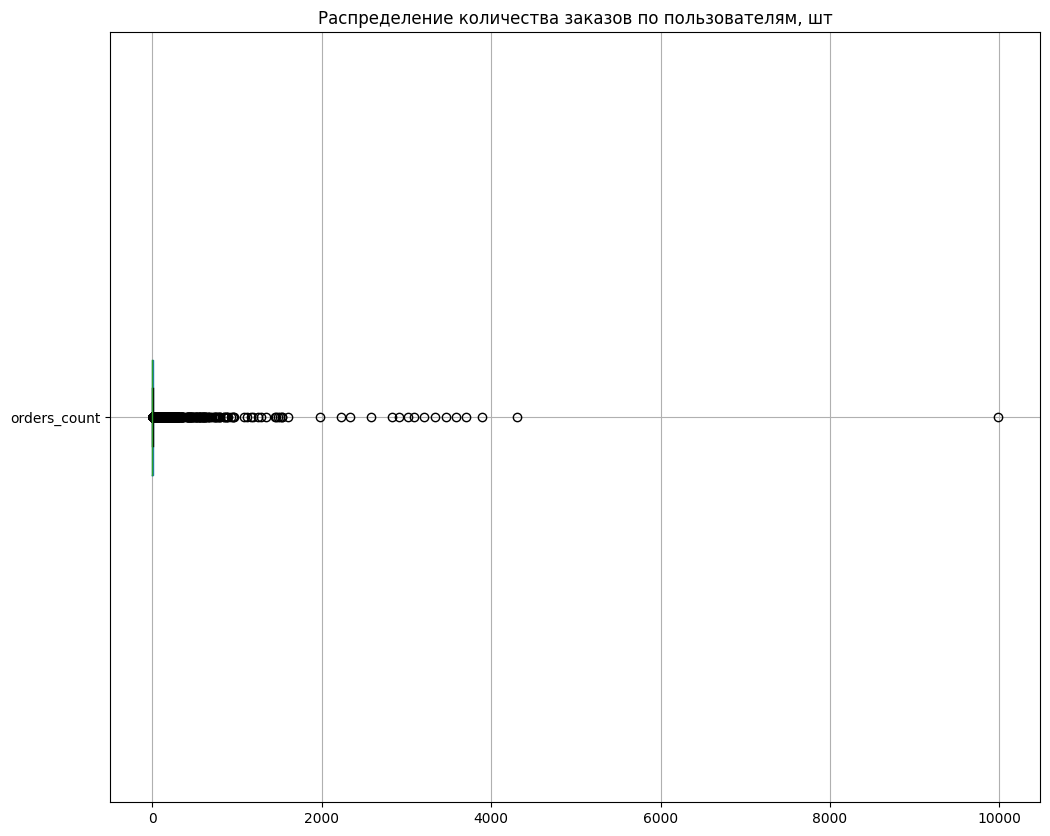

In [49]:
# Построим диаграмму распределения, потому что максимальное число заказов аномально большое, и необходимо дополнительно изучить выбросы

plot3 = profile_df.boxplot(column='orders_count',
                           vert=False,
                           grid=True,
                           figsize=(12, 10))

plot3.set_title('Распределение количества заказов по пользователям, шт')
plt.show()

In [50]:
# Рассчитаем 95% персентиль по числу заказов

order_count_95pers = profile_df['orders_count'].quantile(0.95)
print(f'В 95 персентиль попадает число: {order_count_95pers}')

В 95 персентиль попадает число: 31.0


In [51]:
# Для более качественного исследования данных необходимо отсечь выбросы по 95 персентилю

# Фильтруем данные по значению 99 персентиля  и выше 0

filtered_profile_df = profile_df.loc[profile_df['orders_count']<order_count_95pers].reset_index()

# Проверяем

filtered_profile_df.info()

# Количество отфильтрованных строк
print(f'В результате фильтрации выборка уменьшена на: {profile_df.shape[0] - filtered_profile_df.shape[0]} строк, что составляет {round((profile_df.shape[0] - filtered_profile_df.shape[0]) / profile_df.shape[0] * 100, 1)} %' )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20591 entries, 0 to 20590
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  20591 non-null  int64         
 1   user_id                20591 non-null  object        
 2   first_order            20591 non-null  datetime64[ns]
 3   last_order             20591 non-null  datetime64[ns]
 4   orders_count           20591 non-null  int64         
 5   avg_revenue            20591 non-null  float64       
 6   avg_tickets            20591 non-null  float64       
 7   avg_days_between       12344 non-null  float32       
 8   device_type_canonical  20591 non-null  object        
 9   region_name            20591 non-null  object        
 10  service_name           20591 non-null  object        
 11  event_type_main        20591 non-null  object        
 12  is_five                20591 non-null  bool          
 13  i

### Выводы

Таким образом, мы получили профиль пользователей, проанализировали данные на выбросы и аномалии, отфильтровали выбросы. 
Также удалось расчитать средние значения по основным параметрам:
1. Всего для исследования будет использоваться: 20 591 пользователь
2. Среднее число билетов в заказе: 2.75
3. Средняя выручка с одного заказа: 550 руб
4. Более 32% пользователей имеют 2 и более заказов, более 28% имеют 5 и более заказов

### 4. Исследовательский анализ данных

Для исследовательского анализа будем использовать отфильтрованный датасет filtered_profile_df

#### 4.1 Исследование признаков первого заказа и их связи с возвращением на платформу

Сгруппируем пользователей по признакам: 
1. По типу их первого мероприятия
2. По типу устройства, с которого совершена первая покупка
3. По региону проведения мероприятия из первого заказа
4. По билетному оператору, продавшему билеты на первый заказ

In [52]:
# Для расчета долей пользователей по сегментам запишем в переменную total общее число строк в датафрейме

total = filtered_profile_df.shape[0]
print(f'Всего пользователей в датафрейме: {total}')

Всего пользователей в датафрейме: 20591


In [53]:
# Группируем по типу первого мероприятия и считаем долю пользователей для каждого типа

# Считаем число пользователей для каждого типа мероприятия
first_event_type = filtered_profile_df.groupby('event_type_main')['user_id'].count().reset_index()

# Считаем долю пользователей
for et in first_event_type:
  first_event_type['user_share'] = round(first_event_type['user_id'] / total, 3)


print(first_event_type.sort_values(by='user_share', ascending = False))

  event_type_main  user_id  user_share
2        концерты     9221       0.448
1          другое     4991       0.242
5           театр     4074       0.198
4         стендап     1073       0.052
3           спорт      740       0.036
0        выставки      399       0.019
6            ёлки       93       0.005


In [54]:
# Считаем данные по пользователям по типам устройств
first_device_type = filtered_profile_df.groupby('device_type_canonical')['user_id'].count().reset_index()

# Считаем долю по пользователям по типам устройств
for dt in first_device_type:
  first_device_type['user_share'] = round(first_device_type['user_id'] / total, 2)

print(first_device_type.sort_values(by='user_share', ascending = False))

  device_type_canonical  user_id  user_share
1                mobile    17068        0.83
0               desktop     3523        0.17


In [55]:
# Считаем данные по пользователям по регионам
first_region_name = filtered_profile_df.groupby('region_name')['user_id'].count().reset_index()

# Считаем долю пользователей по регионам
for rn in first_region_name:
  first_region_name['user_share'] = round(first_region_name['user_id'] / total, 4)

print(first_region_name.sort_values(by='user_share', ascending = False))

                 region_name  user_id  user_share
23        Каменевский регион     6677      0.3243
60      Североярская область     3622      0.1759
77       Широковская область     1186      0.0576
45          Озернинский край      662      0.0321
41      Малиновоярский округ      516      0.0251
..                       ...      ...         ...
17            Залесский край        2      0.0001
5          Верхозёрский край        1      0.0000
56         Светолесский край        1      0.0000
66  Сосноводолинская область        1      0.0000
80        Яснопольский округ        1      0.0000

[81 rows x 3 columns]


In [56]:
# Считаем данные по пользователям по сервисам
first_service_name = filtered_profile_df.groupby('service_name')['user_id'].count().reset_index()

# Считаем долю пользователей по сервисам
for sn in first_region_name:
  first_service_name['user_share'] = round(first_service_name['user_id'] / total, 4)

print(first_service_name.sort_values(by='user_share', ascending = False))

              service_name  user_id  user_share
3       Билеты без проблем     4764      0.2314
22               Мой билет     2857      0.1387
19             Лови билет!     2698      0.1310
4            Билеты в руки     2402      0.1167
23                 Облачко     2130      0.1034
7           Весь в билетах     1233      0.0599
20           Лучшие билеты     1135      0.0551
24               Прачечная      552      0.0268
17            Край билетов      441      0.0214
12            Дом культуры      339      0.0165
33                  Яблоко      310      0.0151
28             Тебе билет!      302      0.0147
11  Городской дом культуры      219      0.0106
13             За билетом!      201      0.0098
21                Мир касс      200      0.0097
5              Быстробилет      161      0.0078
1              Show_ticket      157      0.0076
10          Выступления.ру       97      0.0047
8                Восьмёрка       84      0.0041
6           Быстрый кассир       55     

По всем признакам можно сделать вывод: доли пользователей распределены не равномерно, есть выраженные точки входа по каждому из признаков.

In [57]:
# Для каждого признака расчитаем по сегментам долю пользователей, которые совершили 2 и более заказа. Отобразим данные на графиках

In [58]:
# Считаем число пользователей для каждого типа мероприятия, добавив группировку по наличию признака "2 и более заказов"
first_event_type_2 = filtered_profile_df.groupby(['event_type_main', 'is_two'])['user_id'].count().reset_index()

# Считаем долю с заказами 2 и более по каждому типу. Для этого используем сводную таблицу

pivot_first_event_type_2 = first_event_type_2.pivot_table(
    index='event_type_main',
    columns='is_two',
    values='user_id',
    aggfunc='sum'
)

pivot_first_event_type_2.columns = ['False_count', 'True_count']

pivot_first_event_type_2['total'] = pivot_first_event_type_2['False_count'] + pivot_first_event_type_2['True_count']
pivot_first_event_type_2['true_share'] = (pivot_first_event_type_2['True_count'] / pivot_first_event_type_2['total'] * 100).round(1)

print(pivot_first_event_type_2.sort_values(by='true_share', ascending=False))

                 False_count  True_count  total  true_share
event_type_main                                            
выставки                 148         251    399        62.9
театр                   1555        2519   4074        61.8
концерты                3669        5552   9221        60.2
стендап                  437         636   1073        59.3
другое                  2119        2872   4991        57.5
ёлки                      42          51     93        54.8
спорт                    345         395    740        53.4


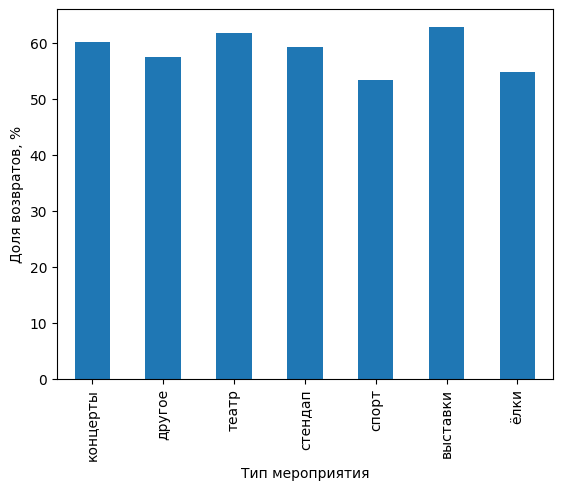

In [59]:
# Визуализируем данные на столбчатой диаграмме

pivot_first_event_type_2.sort_values(by='total', ascending=False).plot(kind='bar', y='true_share', legend = False, xlabel = 'Тип мероприятия', ylabel = 'Доля возвратов, %')
plt.show()

Можно сделать вывод, что по типам мероприятий "Выставки", "Концерты" и "Театры" доля возврата пользователей выше, составляет 60% и более. По другим типам - в диапазоне от 50% до 60% 

In [60]:
# Считаем число пользователей для каждого типа устройств, добавив группировку по наличию признака "2 и более заказов"
first_device_type_2 = filtered_profile_df.groupby(['device_type_canonical', 'is_two'])['user_id'].count().reset_index()

pivot_first_device_type_2 = first_device_type_2.pivot_table(
    index='device_type_canonical',
    columns='is_two',
    values='user_id',
    aggfunc='sum'
)

pivot_first_device_type_2.columns = ['False_count', 'True_count']

pivot_first_device_type_2['total'] = pivot_first_device_type_2['False_count'] + pivot_first_device_type_2['True_count']
pivot_first_device_type_2['true_share'] = (pivot_first_device_type_2['True_count'] / pivot_first_device_type_2['total'] * 100).round(1)

print(pivot_first_device_type_2)

                       False_count  True_count  total  true_share
device_type_canonical                                            
desktop                       1338        2185   3523        62.0
mobile                        6977       10091  17068        59.1


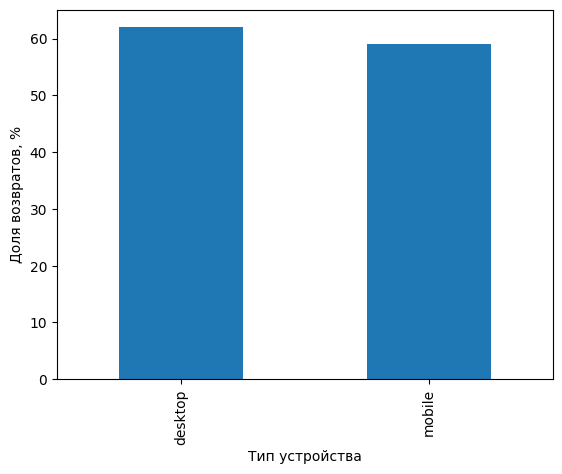

In [61]:
# Визуализируем данные на столбчатой диаграмме

pivot_first_device_type_2.plot(kind='bar', y='true_share', legend = False, xlabel = 'Тип устройства', ylabel = 'Доля возвратов, %')
plt.show()

Можно сделать вывод, что по всем типам устройств - доля возвратов ~60% - одного уровня, и не имеет выраженного выделения, но доля возвратов десктопных устройств чуть выше, чем с мобильных

In [62]:
# Считаем число пользователей для каждого региона, добавив группировку по наличию признака "2 и более заказов"
first_region_name_2 = filtered_profile_df.groupby(['region_name', 'is_two'])['user_id'].count().reset_index()

pivot_first_region_name_2 = first_region_name_2.pivot_table(
    index='region_name',
    columns='is_two',
    values='user_id',
    aggfunc='sum'
)

pivot_first_region_name_2.columns = ['False_count', 'True_count']

pivot_first_region_name_2['total'] = pivot_first_region_name_2['False_count'] + pivot_first_region_name_2['True_count']
pivot_first_region_name_2['true_share'] = (pivot_first_region_name_2['True_count'] / pivot_first_region_name_2['total'] * 100).round(1)

print(pivot_first_region_name_2.sort_values(by='total', ascending=False).head(10))

                      False_count  True_count   total  true_share
region_name                                                      
Каменевский регион         2656.0      4021.0  6677.0        60.2
Североярская область       1360.0      2262.0  3622.0        62.5
Широковская область         438.0       748.0  1186.0        63.1
Озернинский край            304.0       358.0   662.0        54.1
Малиновоярский округ        233.0       283.0   516.0        54.8
Светополянский округ        158.0       282.0   440.0        64.1
Травяная область            177.0       263.0   440.0        59.8
Шанырский регион            142.0       281.0   423.0        66.4
Речиновская область         161.0       260.0   421.0        61.8
Яблоневская область         167.0       229.0   396.0        57.8


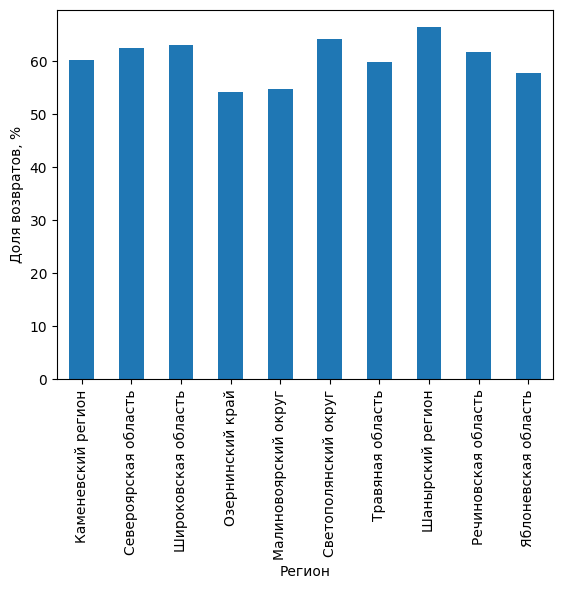

In [63]:
pivot_first_region_name_2.sort_values(by='total', ascending=False).head(10).plot(kind='bar', y='true_share', legend = False, xlabel = 'Регион', ylabel = 'Доля возвратов, %')
plt.show()

Для регионов выведены топ-10 сегментов по числу пользователей в каждом. Доля возвратов колеблется от 57% до 66%. Можно сделать вывод, что нет региона с ярко выраженным высоким % возвратов на сервис, и % возврата находится в двух диапазонах: 50-60% и 60-70% (по 5 регионов в каждом из них). Самый высокий % возврата - в Шанырском округе - 66.4%

In [64]:
# Считаем число пользователей для каждого билетного оператора, добавив группировку по наличию признака "2 и более заказов"
first_service_name_2 = filtered_profile_df.groupby(['service_name', 'is_two'])['user_id'].count().reset_index()

pivot_first_service_name_2 = first_service_name_2.pivot_table(
    index='service_name',
    columns='is_two',
    values='user_id',
    aggfunc='sum'
)

pivot_first_service_name_2.columns = ['False_count', 'True_count']

pivot_first_service_name_2['total'] = pivot_first_service_name_2['False_count'] + pivot_first_service_name_2['True_count']
pivot_first_service_name_2['true_share'] = (pivot_first_service_name_2['True_count'] / pivot_first_service_name_2['total'] * 100).round(1)

print(pivot_first_service_name_2.sort_values(by='total', ascending=False).head(10))

                    False_count  True_count   total  true_share
service_name                                                   
Билеты без проблем       1999.0      2765.0  4764.0        58.0
Мой билет                1172.0      1685.0  2857.0        59.0
Лови билет!              1089.0      1609.0  2698.0        59.6
Билеты в руки             944.0      1458.0  2402.0        60.7
Облачко                   849.0      1281.0  2130.0        60.1
Весь в билетах            479.0       754.0  1233.0        61.2
Лучшие билеты             456.0       679.0  1135.0        59.8
Прачечная                 219.0       333.0   552.0        60.3
Край билетов              159.0       282.0   441.0        63.9
Дом культуры              126.0       213.0   339.0        62.8


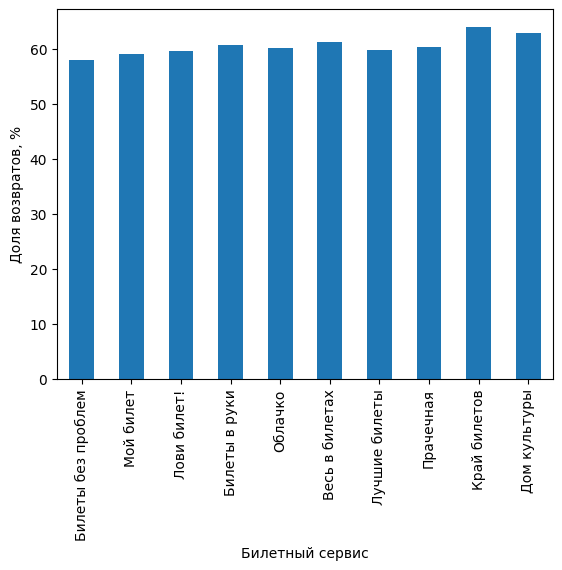

In [65]:
pivot_first_service_name_2.sort_values(by='total', ascending=False).head(10).plot(kind='bar', y='true_share', legend = False, xlabel = 'Билетный сервис', ylabel = 'Доля возвратов, %')
plt.show()

Для билетных сервисов выведены топ-10 сегментов по числу пользователей в каждом. Доля возвратов колеблется от 58% до 64%. Можно сделать вывод, что нет сервиса с ярко выраженным высоким % возвратов на сервис, и % возврата находится на том же уровне, что и для устройств, и типов мероприятий и регионов. Самое высокое значение возвратов у сервиса "Край билетов" - 63.9%

##### Гипотеза 1: 
Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

##### Результат исследования:
Наше исследование опровергает данную гипотезу: число пользователей, которые возвращаются на Яндекс Афишу - для типа "концерты"  выше (60.2% возвратов), чем "спорт" (53.4% возвратов)

##### Гипотеза 2: 

В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

##### Результат исследования:

Наше исследование опровергает данную гипотезу. В регионах с наибольшим числом посетителей мероприятий % возврата немного ниже, чем в менее активных по числу пользователей регионов. 
Топ-2 региона по числу посетителей имеют 60.2% и 62.5% возвратов, а Топ-8 и Топ-9 (регионы из первой десятки по числу посетителей) - 66.4% и 61.8% 

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

In [66]:
# Для построения гистограммы распределения средней выручки с билета необходимо добавить новое поле: 
# avg_revenue_rub - средняя выручка с билета, в датафрейм filtered_profile_df и расчитать его

filtered_profile_df['avg_revenue_rub'] = round(filtered_profile_df['avg_revenue'] / filtered_profile_df['avg_tickets'], 1)

# Проверяем

filtered_profile_df.info()
filtered_profile_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20591 entries, 0 to 20590
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  20591 non-null  int64         
 1   user_id                20591 non-null  object        
 2   first_order            20591 non-null  datetime64[ns]
 3   last_order             20591 non-null  datetime64[ns]
 4   orders_count           20591 non-null  int64         
 5   avg_revenue            20591 non-null  float64       
 6   avg_tickets            20591 non-null  float64       
 7   avg_days_between       12344 non-null  float32       
 8   device_type_canonical  20591 non-null  object        
 9   region_name            20591 non-null  object        
 10  service_name           20591 non-null  object        
 11  event_type_main        20591 non-null  object        
 12  is_five                20591 non-null  bool          
 13  i

,index,user_id,first_order,last_order,orders_count,avg_revenue,avg_tickets,avg_days_between,device_type_canonical,region_name,service_name,event_type_main,is_five,is_two,avg_revenue_rub
0,0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,NaN,mobile,Каменевский регион,Край билетов,театр,False,False,380.5
1,1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.0,mobile,Каменевский регион,Мой билет,выставки,False,True,258.0
2,2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.0,mobile,Североярская область,Лови билет!,другое,False,True,287.7
3,3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,NaN,desktop,Каменевский регион,Край билетов,театр,False,False,229.5
4,4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.0,mobile,Поленовский край,Лучшие билеты,театр,False,True,40.9


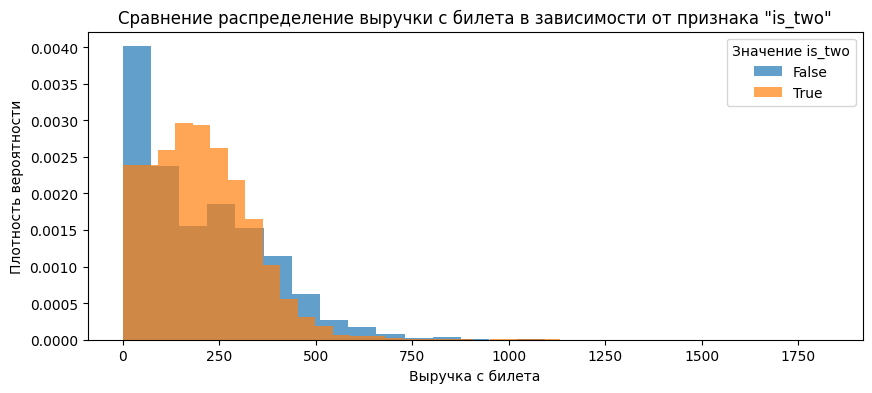

In [67]:
# Строим гистограмму распределения средней выручки с билета
# Создаём фигуру графика
plt.figure(figsize=(10, 4))

# Строим гистограммы для каждого значения is_two
for i in filtered_profile_df['is_two'].unique():
    # Фильтруем данные по значению столбца is_two
    filtered_profile_df.loc[filtered_profile_df['is_two'] == i, 'avg_revenue_rub'].plot(
        kind='hist',
        density=True,
        bins=25,
        alpha=0.7,
        label=f'{i}',
        legend=True
    )

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение распределение выручки с билета в зависимости от признака "is_two"')
plt.xlabel('Выручка с билета')
plt.ylabel('Плотность вероятности')
plt.legend(title='Значение is_two')
plt.show() 

Из гистограммы распределения видно, что наибольшее число пользователей совершивших один заказ находится в диапазонах выручки с билета до 70 рублей (одна корзина на графике ~ 70 руб), после идет значительное снижение. У пользователей совершивших 2 и более заказов - ниже доля пользователей в заказах до 70 руб с билета, выше доля в диапазонах выручки 70-400 руб с билета, снижение более плавное. В заказах стоимостью 400 с билета и выше - разовых заказов больше.

In [68]:
# Для сравнения выручки с заказа у пользователей с 2-4 билетам с 5 и выше - отфильтруем наш датафрейм по is_two = True и 
# построим гистограмму распределения по признаку is_five

filtered_profile_df_2_only = filtered_profile_df.loc[filtered_profile_df['is_two'] == True]

# Проверяем

filtered_profile_df_2_only.info()
filtered_profile_df_2_only.head()

<class 'pandas.core.frame.DataFrame'>
Index: 12276 entries, 1 to 20588
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  12276 non-null  int64         
 1   user_id                12276 non-null  object        
 2   first_order            12276 non-null  datetime64[ns]
 3   last_order             12276 non-null  datetime64[ns]
 4   orders_count           12276 non-null  int64         
 5   avg_revenue            12276 non-null  float64       
 6   avg_tickets            12276 non-null  float64       
 7   avg_days_between       12276 non-null  float32       
 8   device_type_canonical  12276 non-null  object        
 9   region_name            12276 non-null  object        
 10  service_name           12276 non-null  object        
 11  event_type_main        12276 non-null  object        
 12  is_five                12276 non-null  bool          
 13  is_two

,index,user_id,first_order,last_order,orders_count,avg_revenue,avg_tickets,avg_days_between,device_type_canonical,region_name,service_name,event_type_main,is_five,is_two,avg_revenue_rub
1,1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.000000,mobile,Каменевский регион,Мой билет,выставки,False,True,258.0
2,2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.000000,mobile,Североярская область,Лови билет!,другое,False,True,287.7
4,4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.000000,mobile,Поленовский край,Лучшие билеты,театр,False,True,40.9
5,5,000cf0659a9f40f,2024-06-20,2024-06-21,13,1175.808462,3.307692,0.083333,mobile,Широковская область,Лови билет!,концерты,True,True,355.5
6,6,00147c9209d45d3,2024-06-25,2024-06-25,2,352.945000,1.500000,0.000000,mobile,Каменевский регион,Облачко,концерты,False,True,235.3


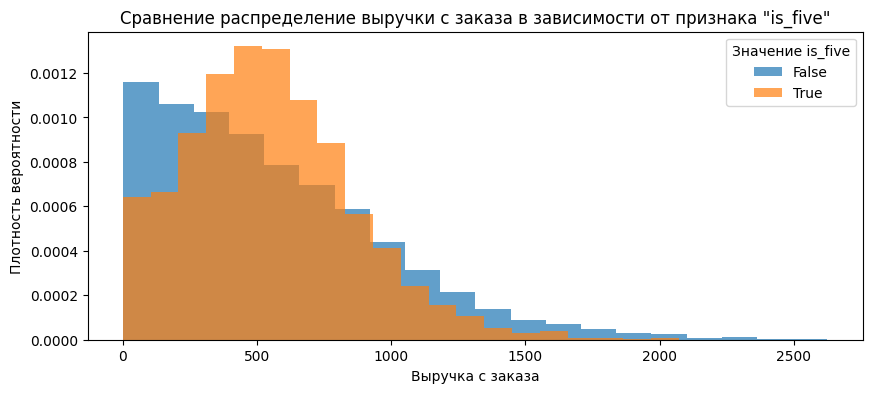

In [69]:
# Строим гистограмму распределения средней выручки с заказа
# Создаём фигуру графика
plt.figure(figsize=(10, 4))

# Строим гистограммы для каждого значения is_five
for i in filtered_profile_df_2_only['is_five'].unique():
    # Фильтруем данные по значению столбца is_two
    filtered_profile_df_2_only.loc[filtered_profile_df_2_only['is_five'] == i, 'avg_revenue'].plot(
        kind='hist',
        density=True,
        bins=20,
        alpha=0.7,
        label=f'{i}',
        legend=True
    )

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение распределение выручки с заказа в зависимости от признака "is_five"')
plt.xlabel('Выручка с заказа')
plt.ylabel('Плотность вероятности')
plt.legend(title='Значение is_five')
plt.show() 

Между группами 2-4 и 5+ заказов на графике видно различие: группа 2-4 заказа имеет максимальную долю в заказах до 500р с плавным снижением. Группа 5+ - имеет выручку с заказа выше в диапазонах от 300 до 800 руб, сначала распределение повышается, потом снижается, имеет пик в диапазоне 500-600 руб. Можно сделать вывод, что у пользователей с 5+ заказами выручка с заказа выше, чем у тех, кто сделал 2-4 заказа.

Но в диапазонах выручки выше 1000 руб - больше доля группы 2-4 заказа.

In [70]:
# Разобьем пользователей в датафрейме filtered_profile_df на сегменты в зависимости от среднего числа билетов в заказе
# Запишем сегмент в новое поле ticket_seg

# Напишем функцию для сегментации
def ticket_segments(row):
    if (row['avg_tickets'] >= 1) & (row['avg_tickets'] < 2):
        return "1-2 seg"
    elif (row['avg_tickets'] >= 2) & (row['avg_tickets'] < 3):
        return "2-3 seg"
    elif (row['avg_tickets'] >= 3) & (row['avg_tickets'] < 5):
        return "3-5 seg"
    elif row['avg_tickets'] >= 5:
        return "5+ seg"

# Применим функцию для нашего датафрейма
filtered_profile_df['ticket_seg'] = filtered_profile_df.apply(ticket_segments, axis=1)

# Проверяем

filtered_profile_df.info()
filtered_profile_df['ticket_seg'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20591 entries, 0 to 20590
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  20591 non-null  int64         
 1   user_id                20591 non-null  object        
 2   first_order            20591 non-null  datetime64[ns]
 3   last_order             20591 non-null  datetime64[ns]
 4   orders_count           20591 non-null  int64         
 5   avg_revenue            20591 non-null  float64       
 6   avg_tickets            20591 non-null  float64       
 7   avg_days_between       12344 non-null  float32       
 8   device_type_canonical  20591 non-null  object        
 9   region_name            20591 non-null  object        
 10  service_name           20591 non-null  object        
 11  event_type_main        20591 non-null  object        
 12  is_five                20591 non-null  bool          
 13  i

array(['3-5 seg', '2-3 seg', '1-2 seg', '5+ seg'], dtype=object)

In [71]:
# Теперь сгруппируем необходимые для анализа данные в новый датафрейм

profile_df_ticket_seg = filtered_profile_df[['user_id', 'is_two', 'ticket_seg']].groupby(['ticket_seg', 'is_two'])['user_id'].count().reset_index()

# Проверяем

print(profile_df_ticket_seg)

  ticket_seg  is_two  user_id
0    1-2 seg   False     1167
1    1-2 seg    True     1222
2    2-3 seg   False     2498
3    2-3 seg    True     6164
4    3-5 seg   False     4117
5    3-5 seg    True     4766
6     5+ seg   False      533
7     5+ seg    True      124


In [72]:
# Посчитаем долю повторных покупок по каждому сегменту, соберем данные в сводную таблицу

pivot_profile_df_ticket_seg = profile_df_ticket_seg.pivot_table(
    index='ticket_seg',
    columns='is_two',
    values='user_id',
    aggfunc='sum'
)

pivot_profile_df_ticket_seg.columns = ['False_count', 'True_count']

pivot_profile_df_ticket_seg['total'] = pivot_profile_df_ticket_seg['False_count'] + pivot_profile_df_ticket_seg['True_count']
pivot_profile_df_ticket_seg['true_share'] = (pivot_profile_df_ticket_seg['True_count'] / pivot_profile_df_ticket_seg['total'] * 100).round(1)

print(pivot_profile_df_ticket_seg.sort_values(by='total', ascending=False))

            False_count  True_count  total  true_share
ticket_seg                                            
3-5 seg            4117        4766   8883        53.7
2-3 seg            2498        6164   8662        71.2
1-2 seg            1167        1222   2389        51.2
5+ seg              533         124    657        18.9


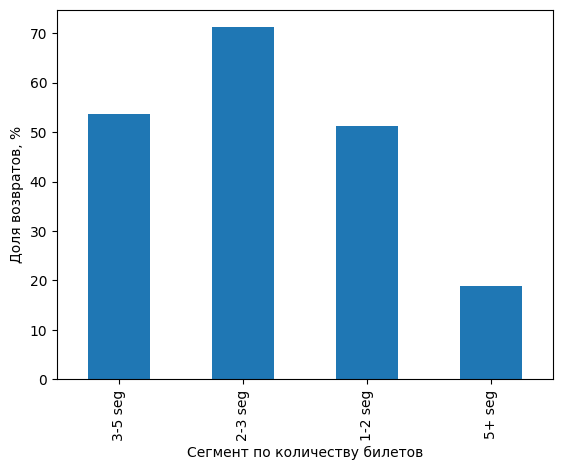

In [73]:
# Выведем визуализацию по сегментам

pivot_profile_df_ticket_seg.sort_values(by='total', ascending=False).plot(kind='bar', y='true_share', legend = False, xlabel = 'Сегмент по количеству билетов', ylabel = 'Доля возвратов, %')
plt.show()


Можно сделать вывод, что в сегменте 2-3 билета на заказ - наиболее высокая доля возвратов - 71.2%. Напротив, в сегменте с 5+ билетами - доля возвратов низкая, 18.9%

С точки зрения распределения пользователей по сегментам - пользователи сконцентрированы в двух сегментах - 2-3 билета и 3-5 билетов

#### 4.3 Исследование временных характеристик первого заказа и их влияния на повторные покупки

In [74]:
# Проведем анализ дня недели первой покупки у каждого пользователя. Добавим новое поле в датафрейм: first_purchase_day

filtered_profile_df['first_purchase_day'] = filtered_profile_df['first_order'].dt.strftime('%A')

# Проверяем

filtered_profile_df['first_purchase_day'].unique()

array(['Tuesday', 'Saturday', 'Thursday', 'Sunday', 'Monday', 'Wednesday',
       'Friday'], dtype=object)

In [75]:
# Для необходимого анализа соберем отдельный датафрейм

filtered_profile_df_dow = filtered_profile_df[['user_id', 'first_purchase_day', 'is_two']].groupby(['first_purchase_day', 'is_two'])['user_id'].count().reset_index()

# Проверяем

print(filtered_profile_df_dow)

   first_purchase_day  is_two  user_id
0              Friday   False     1296
1              Friday    True     1836
2              Monday   False     1084
3              Monday    True     1710
4            Saturday   False     1225
5            Saturday    True     1869
6              Sunday   False     1098
7              Sunday    True     1518
8            Thursday   False     1255
9            Thursday    True     1754
10            Tuesday   False     1204
11            Tuesday    True     1792
12          Wednesday   False     1153
13          Wednesday    True     1797


In [76]:
# Для подсчета повторных покупок соберем сводную таблицу и выведем визуализацию повторных покупок по дню недели

pivot_filtered_profile_df_dow = filtered_profile_df_dow.pivot_table(
    index='first_purchase_day',
    columns='is_two',
    values='user_id',
    aggfunc='sum'
)

pivot_filtered_profile_df_dow.columns = ['False_count', 'True_count']

pivot_filtered_profile_df_dow['total'] = pivot_filtered_profile_df_dow['False_count'] + pivot_filtered_profile_df_dow['True_count']
pivot_filtered_profile_df_dow['true_share'] = (pivot_filtered_profile_df_dow['True_count'] / pivot_filtered_profile_df_dow['total'] * 100).round(1)

print(pivot_filtered_profile_df_dow.sort_values(by='total', ascending=False))

                    False_count  True_count  total  true_share
first_purchase_day                                            
Friday                     1296        1836   3132        58.6
Saturday                   1225        1869   3094        60.4
Thursday                   1255        1754   3009        58.3
Tuesday                    1204        1792   2996        59.8
Wednesday                  1153        1797   2950        60.9
Monday                     1084        1710   2794        61.2
Sunday                     1098        1518   2616        58.0


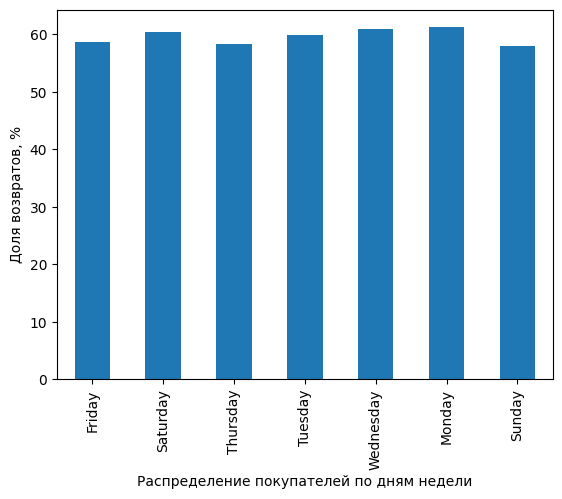

In [77]:
# Выведем визуализацию по дням недели, отсортируем по числу покупателей по убыванию

pivot_filtered_profile_df_dow.sort_values(by='total', ascending=False).plot(kind='bar', y='true_share', legend = False, xlabel = 'Распределение покупателей по дням недели', ylabel = 'Доля возвратов, %')
plt.show()


Вывод: дни недели не имеют ярко выраженного различия, однако, видно, что в воскресенья и понедельники доля первых покупок ниже, чем в остальные дни, кооторые распределились равномерно. Доля возвратов покупателей колеблется от 58% до 61% и также не имеет ярко выделенной зависимости

In [78]:
# Рассчитаем показатель Среднее время между покупками для двух сегментов пользователей: совершившие 2-4 покупки и 5+ покупок
# Пользователи, у которых признак is_two = True, is_five = False - совершили от 2 до 4 покупок, пользователи у которых 
# is_two = True, is_five = True - совершили 5+ покупок

filtered_profile_df.loc[filtered_profile_df['is_two']==True].groupby(['is_two', 'is_five'])['avg_days_between'].mean().reset_index()

,is_two,is_five,avg_days_between
0,True,False,21.238056
1,True,True,11.146338


Вывод: чем больше заказов сделал пользователь, тем ниже среднее значение времени между заказами

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

In [79]:
# Для расчета коэффициента хи-квадрат импортируем нужные библиотеки
from phik import phik_matrix

In [80]:
filtered_profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20591 entries, 0 to 20590
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  20591 non-null  int64         
 1   user_id                20591 non-null  object        
 2   first_order            20591 non-null  datetime64[ns]
 3   last_order             20591 non-null  datetime64[ns]
 4   orders_count           20591 non-null  int64         
 5   avg_revenue            20591 non-null  float64       
 6   avg_tickets            20591 non-null  float64       
 7   avg_days_between       12344 non-null  float32       
 8   device_type_canonical  20591 non-null  object        
 9   region_name            20591 non-null  object        
 10  service_name           20591 non-null  object        
 11  event_type_main        20591 non-null  object        
 12  is_five                20591 non-null  bool          
 13  i

In [81]:
# Построим корелляционную матрицу для нашего датафрейма filtered_profile_df

# Отфильтруем датафрейм с признаками профиля пользователя
phik_profile_df = filtered_profile_df[['avg_tickets', 'avg_revenue_rub','orders_count', 'avg_days_between', 'device_type_canonical', 'region_name', 'service_name', 'event_type_main']]

correlation_matrix = phik_profile_df.phik_matrix(interval_cols=['avg_days_between', 'avg_revenue_rub'])

print(correlation_matrix)

                       avg_tickets  avg_revenue_rub  orders_count  \
avg_tickets               1.000000         0.000000      0.992547   
avg_revenue_rub           0.000000         1.000000      0.154875   
orders_count              0.992547         0.154875      1.000000   
avg_days_between          0.000000         0.047317      0.529479   
device_type_canonical     0.102303         0.042053      0.041088   
region_name               0.000000         0.379519      0.000000   
service_name              0.000000         0.411470      0.031234   
event_type_main           0.000000         0.319549      0.037870   

                       avg_days_between  device_type_canonical  region_name  \
avg_tickets                    0.000000               0.102303     0.000000   
avg_revenue_rub                0.047317               0.042053     0.379519   
orders_count                   0.529479               0.041088     0.000000   
avg_days_between               1.000000               0.025015

In [82]:
# Разделим значение orders_count на сегменты и присвоим их в новое поле total_orders_seg

# Напишем функцию для сегментации
def order_segments(row):
    if row['orders_count'] == 1:
        return "1 order seg"
    elif (row['avg_tickets'] >= 2) & (row['avg_tickets'] <= 4):
        return "2-4 order seg"
    elif row['avg_tickets'] >= 5:
        return "5+ order seg"

# Применим функцию для нашего датафрейма
filtered_profile_df['total_orders_seg'] = filtered_profile_df.apply(order_segments, axis=1)

# Проверяем

filtered_profile_df.groupby(['total_orders_seg'])['user_id'].count()

total_orders_seg
1 order seg       8315
2-4 order seg    10622
5+ order seg       124
Name: user_id, dtype: int64

In [83]:
# Посмотрим матрицу заново

# Отфильтруем датафрейм с признаками профиля пользователя - вместо числа заказов добавим поле total_orders_seg
phik_profile_df = filtered_profile_df[['avg_tickets', 'total_orders_seg', 'avg_revenue_rub', 'avg_days_between', 'device_type_canonical', 'region_name', 'service_name', 'event_type_main']]

correlation_matrix = phik_profile_df.phik_matrix(interval_cols=['avg_days_between', 'avg_revenue_rub'])

print(correlation_matrix)

                       avg_tickets  total_orders_seg  avg_revenue_rub  \
avg_tickets               1.000000          0.903951         0.000000   
total_orders_seg          0.903951          1.000000         0.247362   
avg_revenue_rub           0.000000          0.247362         1.000000   
avg_days_between          0.000000          0.148754         0.047317   
device_type_canonical     0.102303          0.015460         0.042053   
region_name               0.000000          0.090989         0.379519   
service_name              0.000000          0.071061         0.411470   
event_type_main           0.000000          0.050823         0.319549   

                       avg_days_between  device_type_canonical  region_name  \
avg_tickets                    0.000000               0.102303     0.000000   
total_orders_seg               0.148754               0.015460     0.090989   
avg_revenue_rub                0.047317               0.042053     0.379519   
avg_days_between          

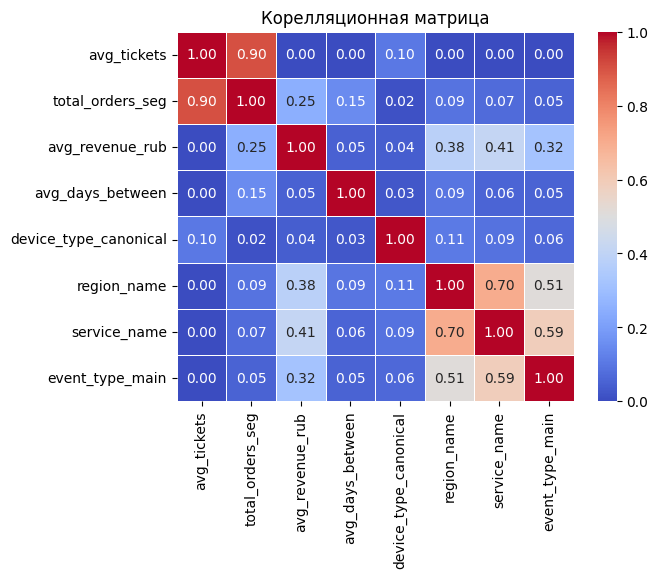

In [84]:
# Построим тепловую карту для визуализации коэффициента

sns.heatmap(data=correlation_matrix, annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm')

plt.title('Корелляционная матрица')
plt.show()

Вывод: с количеством заказа высокий уровень связи показывает признак Среднее число билетов в заказе. Все остальные признаки - не связаны или показывают слабую связь

### Вывод

В работу была принята выборка данных о заказах пользователей Яндекс Афиши. Исходная выборка содержала данные о 290 611 заказах по 14 показателям. В рамках подготовки данных - стоимость заказов была переведена в единую валюту - Рубль РФ с помощью истории изменения курса.

Далее было проведено исследование на пропуски и аномальные данные. Данные были приведены к нужному формату, у части полей была изменена размерность для оптимальной работы с памятью. Также были обнаружены выбросы в поле Выручка с заказа, было принято решение провести фильтрацию по 99 персентилю. Всего было отфильтровано 3.1% данных.

Далее был построен профиль пользователей: всего в выборке присутствовали данные по 21 694 пользователям, которые совершали данные заказы.
Средняя выручка с заказа по всей выборке: 550 рублей. 61.67% пользователей осуществили 2 и более заказов, 28.87% - 5 и более.
Среднее число дней между заказами у пользователей с 2 и более заказами: 15.9

Следующим шагом были отфильтрованы аномальные выбосы в поле числа заказов на 1 пользователя, в результате этой операции выборка сократилась на 3.1 %

Из анализа признаков по заказам видно, что пользователи, сделавшие заказы на Выставки, Концерты и Театры охотнее возвращались на платформу (более 60% возвратов). Также чаще всего возвращались на платформу пользователи Шанырского округа. Вид устройства первого заказа не оказал явного влияния на % возврата.

Также возвраты пользователей связаны с выручкой на билет: пользователи, тратившие менее 100 руб в расчете на билет реже возвращались на платформу, чем те пользователи, которые тратили 200-400 рублей. Также выраженным признаком возврата на платформу является сегмент 2-3 билета, что можно связать с походами на мероприятия с семьей и друзьями: такие пользователи возвращались на платформу более, чем в 70% случаев.

День недели не оказал выраженного влияния на возвраты, однако можно заметить, что пользователи менее активно покупали билеты в воскресенья и понедельники. Также на число заказов на пользователя сильное воздействие оказывал признак количества билетов на пользователя: коэффициент корелляции составил 0.9



### Рекомендации

Исходя из проведенного анализа, можно порекомендовать усилить маркетинговую активность в воскресенья и понедельники, чтобы повысиить активность пользователей. 
Также стоит обратить внимание и повысить активность в сегменте покупок категории Спорт. Неплохо было бы проработать программу лояльности для возврата пользователей, которые покупали 5 и более билетов, тк % возврата среди них самый низкий. Возможно, это связано с эпизодическими покупками на большую компанию